In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [100]:
#In this stage we are raeding the data from dataset.
sheet_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
url = 'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_id}'.format(sheet_id=sheet_id)
df = pd.read_csv(url)

In [101]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294.00,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.50,38.81M,-0.02%
2,"Mar 29, 2021",293.30,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.50,287.03,283.85,35.22M,0.30%


In [102]:
df.shape

(311, 7)

In [103]:
df.isna().any()

,0
Date,False
Price,False
Open,False
High,False
Low,False
Vol.,False
Change %,False


In [104]:
df.dtypes

,0
Date,object
Price,float64
Open,float64
High,float64
Low,float64
Vol.,object
Change %,object


In [105]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [106]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00M,-0.76%
2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.02%
2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.71%
2021-03-26,291.22,288.63,292.75,288.32,56.07M,1.59%
2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.30%


#Exploratory Data Analysis

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [108]:
def remove_string(data, column, item):
  data[column] = df[column].str.replace(item, '').astype(float)
  return data[column].dtype

In [109]:
remove_string(df, 'Change %', '%')
remove_string(df, 'Vol.', 'M')


dtype('float64')

In [110]:
df.head()


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.76
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.02
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.71
2021-03-26,291.22,288.63,292.75,288.32,56.07,1.59
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.30


In [111]:
y = df['Price']

In [112]:
type(y)

pandas.core.series.Series

In [113]:

y.describe()

,Price
count,311.000000
mean,234.524019
std,32.079847
min,174.270000
25%,207.700000
50%,229.140000
75%,264.380000
max,293.300000


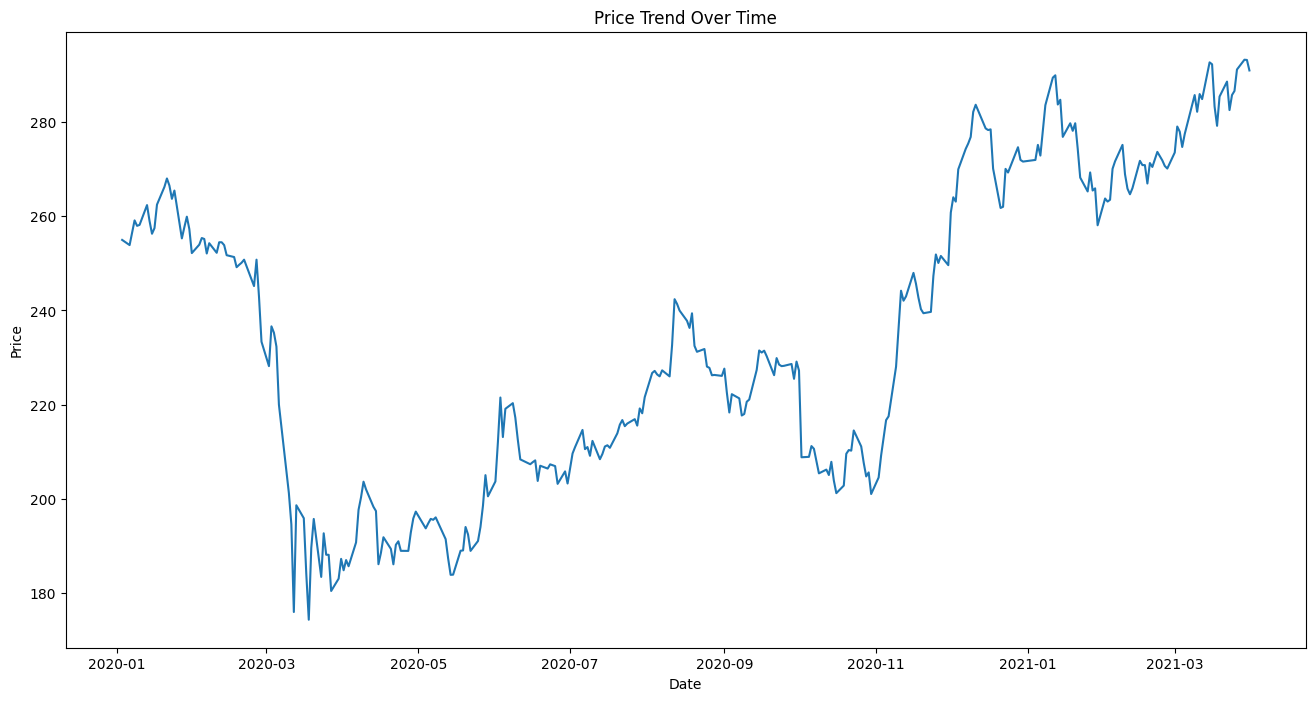

In [114]:
#Plot the price changes during time.
plt.figure(figsize=(16, 8))
plt.plot(y)
plt.title('Price Trend Over Time')  # Add a descriptive title
plt.xlabel('Date')  # Add label for x-axis
plt.ylabel('Price')  # Add label for y-axis
plt.show()


This code decomposes the 'Price' time series into trend, seasonality, and residuals using an additive model with a 90-day period.
The trend captures long-term movement, seasonal captures repeating patterns, and residual represents random noise.
This helps in understanding stock price behavior for better forecasting.

In [115]:
decomp = seasonal_decompose(df['Price'], model='additive', period=90)
seasonal = decomp.seasonal
trend = decomp.trend
residual = decomp.resid

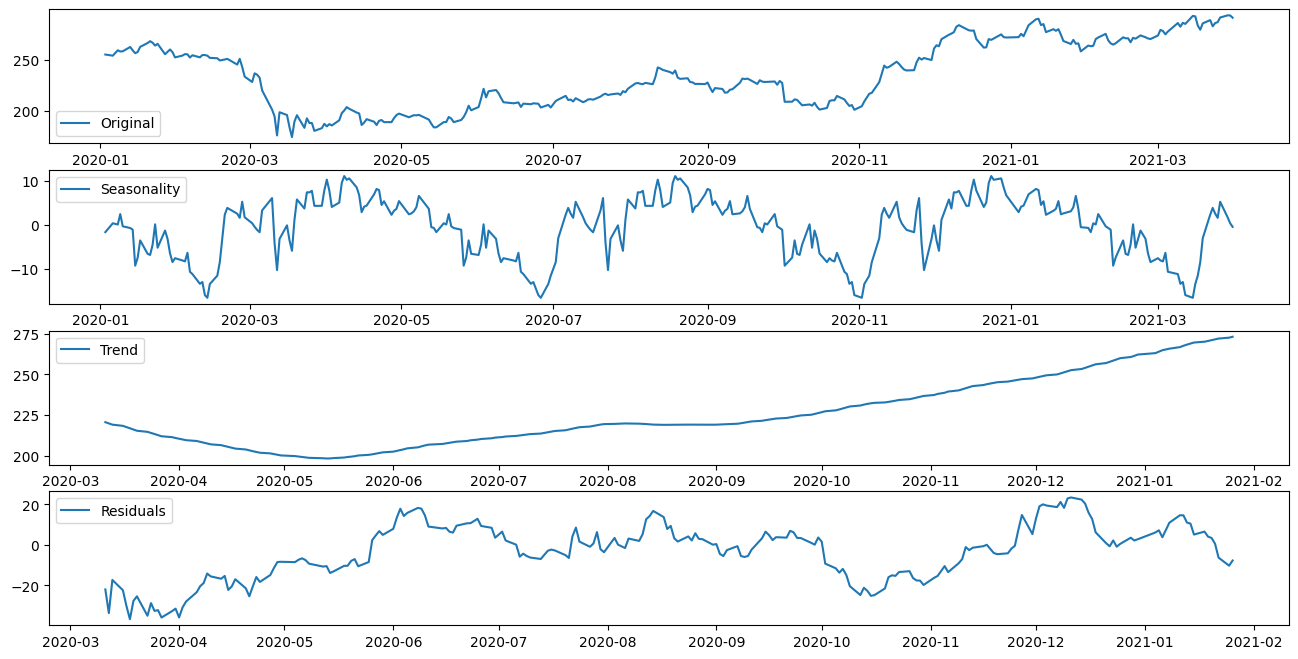

In [116]:
plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['Price'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.show()

#Testing For Stationarity
Testing for stationarity checks whether a time series has constant mean, variance, and autocorrelation over time, ensuring it is suitable for forecasting models like ARIMA.

In [117]:
from statsmodels.tsa.stattools import kpss
kpss_stat, p_value, n_lags, critical_value = kpss(df['Price'])
def stationarity_check(value):
    if value < 0.05:
        print("Data is not stationary")
    else:
        print("Data is stationary")
stationarity_check(p_value)

Data is not stationary


In [118]:
df['price_diff'] = df['Price'].diff()
df = df.dropna()

To make data stationary, we apply windowing techniques such as rolling statistics to smooth fluctuations and stabilize the mean and variance over time.

In [119]:
df['rolling_mean_diff'] = df['price_diff'].rolling(window=5).mean()
df = df.dropna()

In [120]:

df.head()


,Price,Open,High,Low,Vol.,Change %,price_diff,rolling_mean_diff
Date,,,,,,,,
2021-03-24,285.79,283.40,288.00,282.25,46.41,1.13,-0.87,-1.046
2021-03-23,282.60,287.56,288.30,282.11,70.76,-2.10,-3.19,-2.130
2021-03-22,288.65,285.00,291.20,283.08,62.76,1.11,6.05,-0.930
2021-03-19,285.47,279.00,286.31,278.03,84.25,2.23,-3.18,-1.150
2021-03-18,279.25,284.04,285.79,278.24,74.13,-1.45,-6.22,-1.482


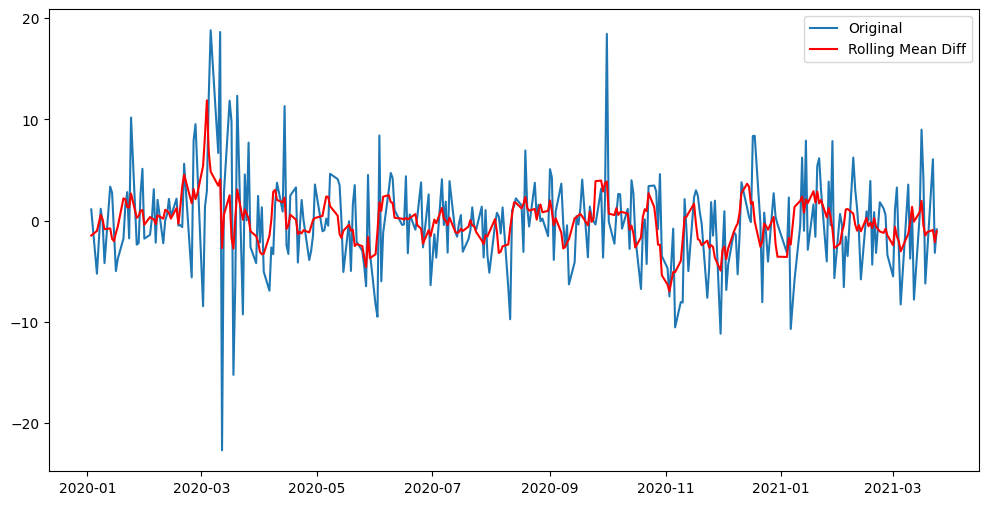

In [121]:
plt.figure(figsize=(12,6))
plt.plot(df['price_diff'], label='Original')
plt.plot(df['rolling_mean_diff'], color='red', label='Rolling Mean Diff')
plt.legend()
plt.show()

In [122]:
stationarity_check(kpss(df['rolling_mean_diff'])[1])

Data is stationary


In [123]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [124]:
# Ensure the index is sorted
df = df.sort_index()


In [125]:
df_train = df.loc['2020-01-01':'2021-01-01']
df_test = df.loc['2021-01-01':]

#Creating The ARIMA Model
This function evaluates an ARIMA model by splitting the data into a training set (2020) and a test set (2021). It iteratively fits an ARIMA model on historical data, forecasts the next value, appends it to history, and calculates the Mean Squared Error (MSE) between predicted and actual test values.
evaluate_arima_model trains an ARIMA model using stock price data from 2020 to early 2021 and tests it on data from 2021 onward. It iteratively fits the model, forecasts one step ahead, updates the history with actual values, and calculates the Mean Squared Error (MSE) to evaluate prediction accuracy. This approach helps assess short-term forecasting performance.

In [126]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mae = mean_absolute_error(data[start_train_size:], predictions)

    return mse , mae, predictions


In [127]:
mse, mae, predictions = evaluate_arima_model(df['rolling_mean_diff'].sort_index(), (1, 2, 1), len(df_train))

#Plotting The Forecast With Bollinger Bands

In [128]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-03-24,-3.626643
2021-03-23,-3.657335
2021-03-22,-1.722661
2021-03-19,-2.395069
2021-03-18,1.397644


In [129]:

f_std = forecast['rolling_mean_diff'].std()

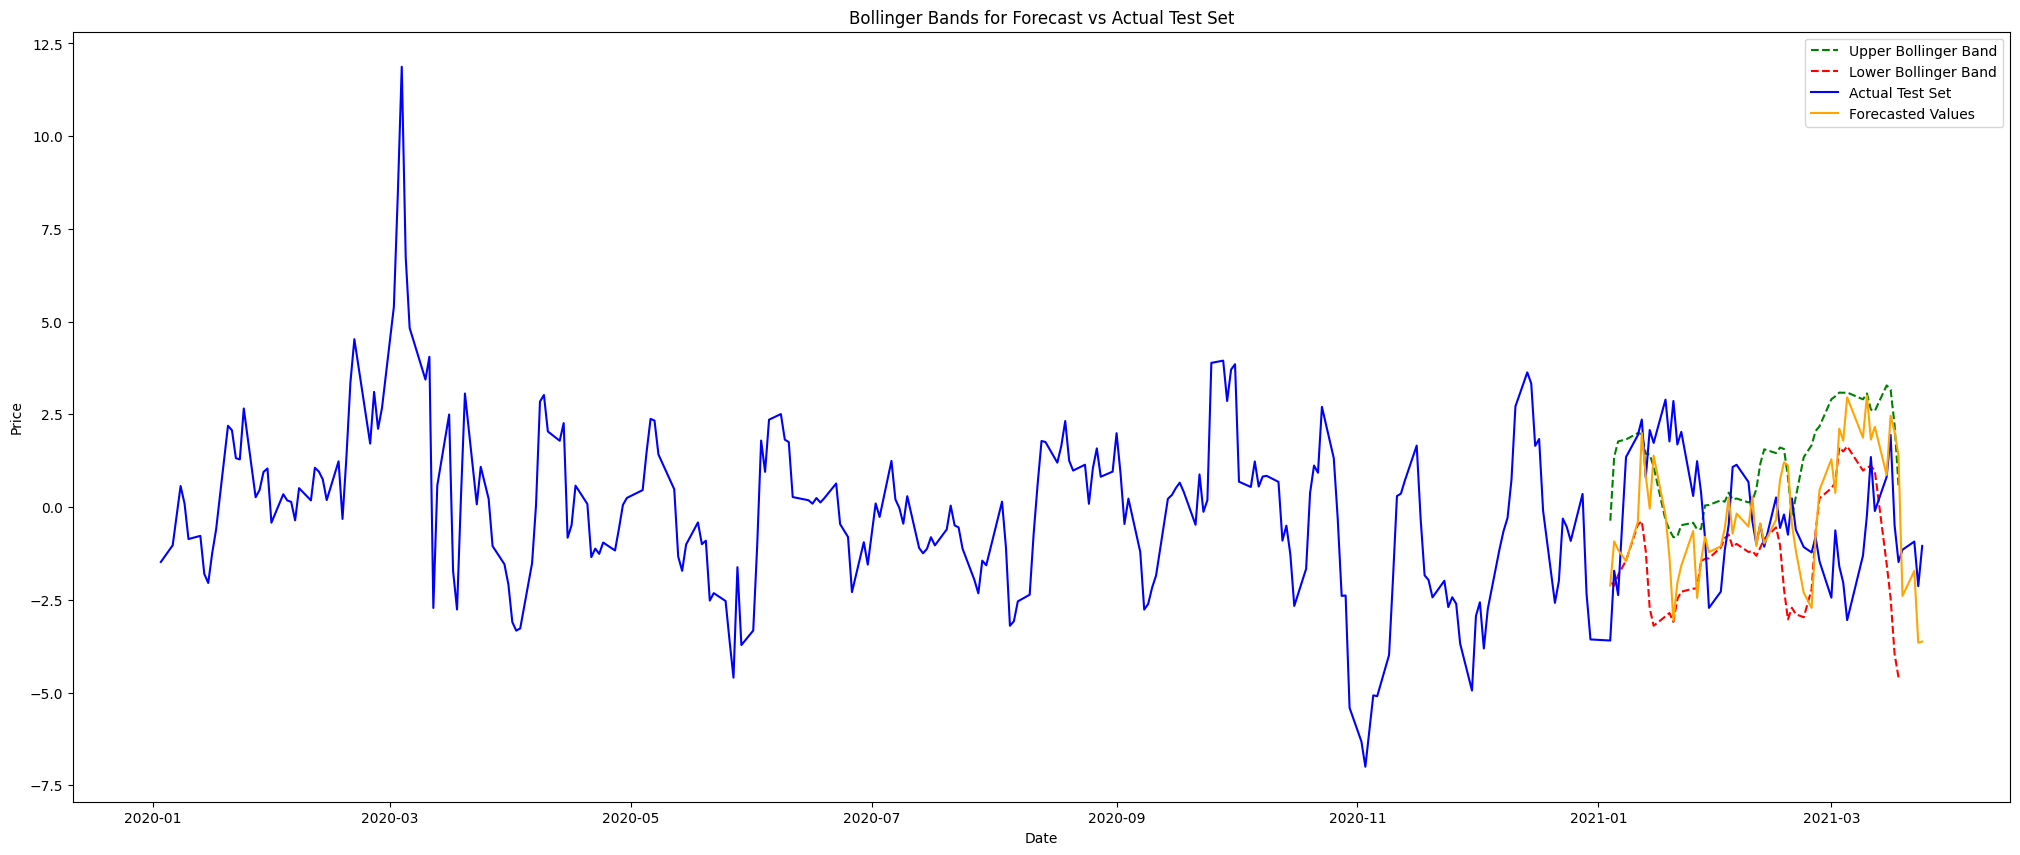

In [130]:
# Calculate Bollinger Bands for the forecast
window = 5  # Rolling window size for Bollinger Bands
forecast['SMA'] = forecast['rolling_mean_diff'].rolling(window=window).mean()
forecast['Rolling_STD'] = forecast['rolling_mean_diff'].rolling(window=window).std()

# Upper and Lower Bands
forecast['Upper_Band'] = forecast['SMA'] + (1.25*forecast['Rolling_STD'])
forecast['Lower_Band'] = forecast['SMA'] - (1.25*forecast['Rolling_STD'])

# Plotting Bollinger Bands for the forecast
plt.figure(figsize=(25, 10))

# Upper and Lower Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Actual test set
plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

# Forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values', color='orange')

# Title and labels
plt.title('Bollinger Bands for Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#Decisions: Buy, Hold, Sell?

            rolling_mean_diff  Upper_Band  Lower_Band Decision
Date                                                          
2021-03-24          -3.626643         NaN         NaN     Hold
2021-03-23          -3.657335         NaN         NaN     Hold
2021-03-22          -1.722661         NaN         NaN     Hold
2021-03-19          -2.395069         NaN         NaN     Hold
2021-03-18           1.397644    0.588958   -4.590584     Sell
2021-03-17           2.032429    2.217540   -3.955537     Hold
2021-03-16           2.464328    3.166423   -2.455755     Hold
2021-03-15           0.864302    3.279764   -1.534311     Hold
2021-03-12           2.164657    2.591037    0.978307     Hold
2021-03-11           1.820242    2.629623    1.108761     Hold
2021-03-10           3.004919    3.062598    1.064781     Hold
2021-03-09           1.871503    2.905380    0.984869     Hold
2021-03-05           2.960380    3.089019    1.639661     Hold
2021-03-04           1.792863    3.081409    1.498554  

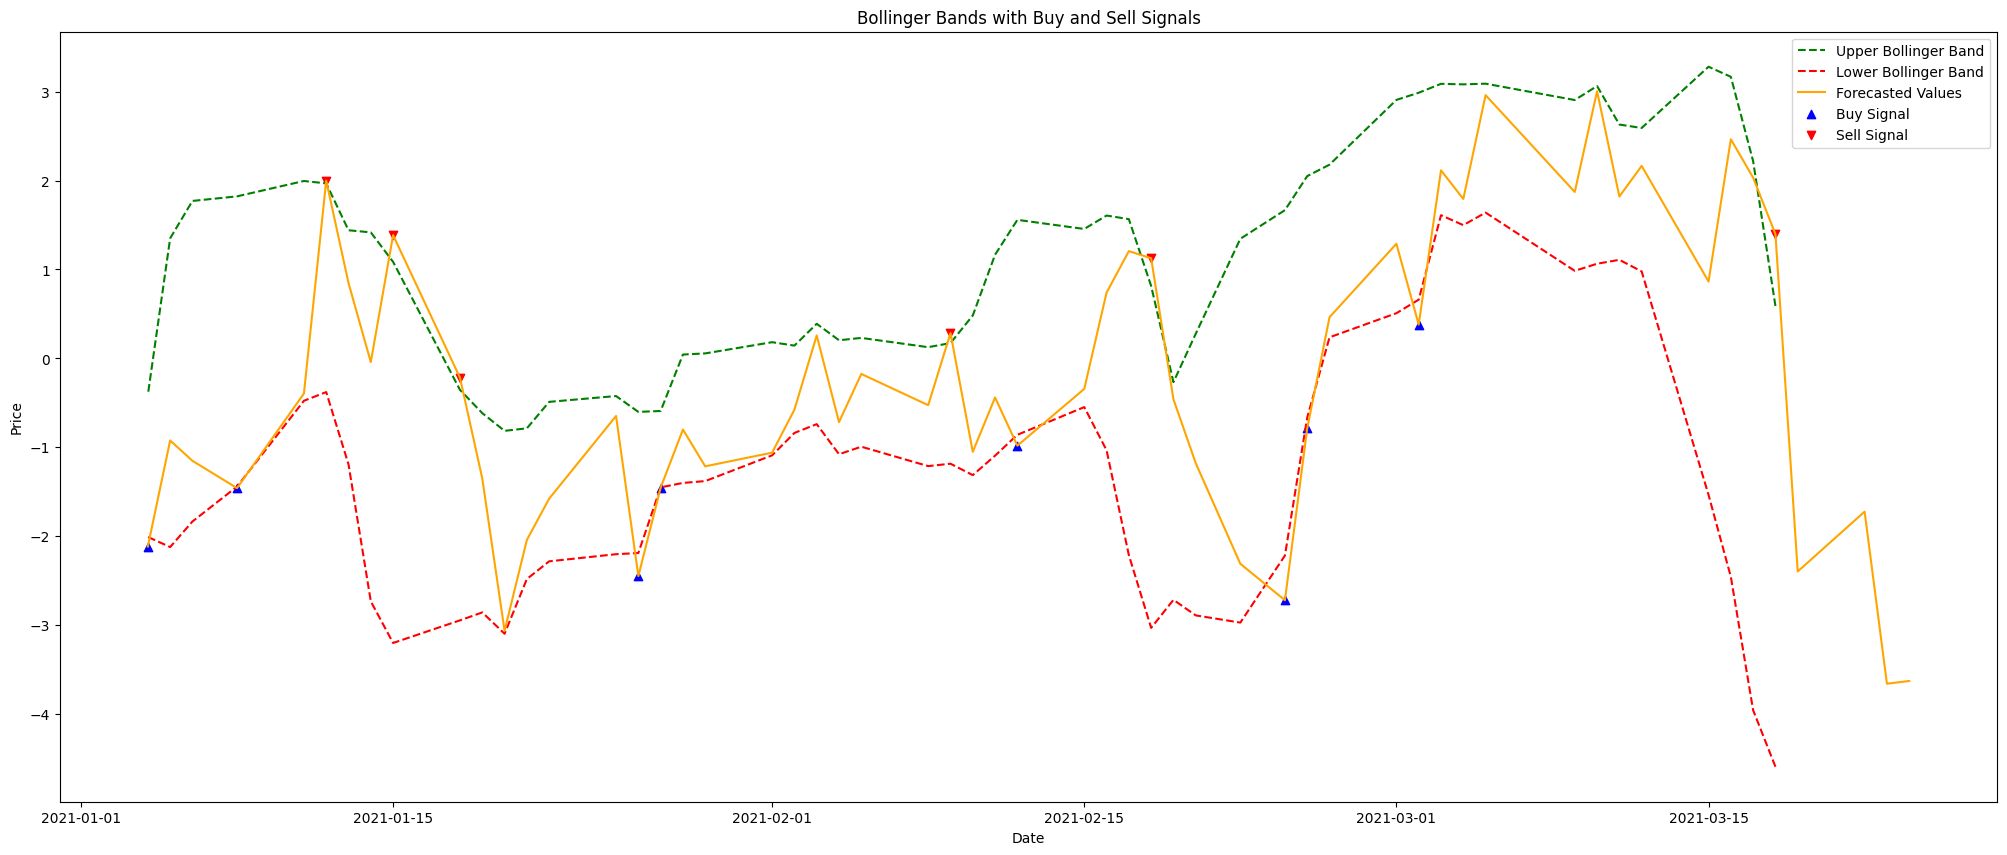

In [131]:
# Create a decision column
forecast['Decision'] = 'Hold'

# Set Buy, Sell, or Hold based on Bollinger Bands
for i in range(len(forecast)):
    if forecast['rolling_mean_diff'].iloc[i] < forecast['Lower_Band'].iloc[i]:
        forecast['Decision'].iloc[i] = 'Buy'
    elif forecast['rolling_mean_diff'].iloc[i] > forecast['Upper_Band'].iloc[i]:
        forecast['Decision'].iloc[i] = 'Sell'
    else:
        forecast['Decision'].iloc[i] = 'Hold'

# Display the last few rows with decisions
print(forecast[['rolling_mean_diff', 'Upper_Band', 'Lower_Band', 'Decision']])

# Plotting decisions
plt.figure(figsize=(25, 10))

# Plot Bollinger Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Plot forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values', color='orange')

# Highlight Buy and Sell points
buy_signals = forecast[forecast['Decision'] == 'Buy']
sell_signals = forecast[forecast['Decision'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['rolling_mean_diff'], label='Buy Signal', color='blue', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['rolling_mean_diff'], label='Sell Signal', color='red', marker='v', alpha=1)

# Title and labels
plt.title('Bollinger Bands with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#Calculation Retun
The calculate_profit function simulates a simple trading strategy based on decisions from an ARIMA model using Bollinger Bands. It starts with zero cash and no holdings, iterates through each row in the forecast DataFrame, and makes buy or sell decisions based on the 'Decision' column. If the decision is 'Buy' and there are no holdings, it purchases one unit at the current price. If the decision is 'Sell' and there are holdings, it sells all units and calculates the profit by subtracting the buy price from the current price. Any remaining unsold holdings are noted as unrealized profit. The total realized profit is printed and returned at the end of the function.

In [135]:
def calculate_profit(forecast):
    cash = 0  # Initial cash balance
    holdings = 0  # Number of units held
    buy_price = 0  # To track the price at which we bought

    for i in range(len(forecast)):
        decision = forecast['Decision'].iloc[i]
        price = forecast['rolling_mean_diff'].iloc[i]

        if decision == 'Buy' and holdings == 0:
            # Buy one unit
            holdings += 1
            buy_price = price
            print(f"Bought at {price} on index {i}")

        elif decision == 'Sell' and holdings > 0:
            # Sell all holdings
            cash += (price - buy_price) * holdings
            print(f"Sold at {price} on index {i} | Profit: {(price - buy_price) * holdings}")
            holdings = 0  # Reset holdings

    # Final statement in case holdings are left unsold
    if holdings > 0:
        print(f"Still holding {holdings} units. Unrealized profit/loss not included.")

    print(f"Total realized profit: {cash}")
    return cash

total_profit = calculate_profit(forecast)
print(f"Total Profit: {total_profit}")


Bought at 0.3801117651203097 on index 15
Sold at 1.126147145755863 on index 23 | Profit: 0.7460353806355533
Bought at -0.9807484954674421 on index 27
Sold at 0.2844903611817472 on index 30 | Profit: 1.2652388566491894
Bought at -1.45290049086989 on index 39
Sold at -0.21684196426416136 on index 46 | Profit: 1.2360585266057287
Bought at -1.4580845277981667 on index 52
Still holding 1 units. Unrealized profit/loss not included.
Total realized profit: 3.2473327638904714
Total Profit: 3.2473327638904714


#Creating The ARIMAX Model
Here is a function to evaluate an ARIMAX model, which includes exogenous variables while using the same approach as the second version of evaluate_arima_model. This function forecasts one step ahead, updates the history, and calculates MSE to assess performance.

In [136]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure Date column is the index
df.index = pd.to_datetime(df.index)

# Select exogenous variables
exog_vars = ['Open', 'High', 'Low', 'Vol.', 'Change %']
df_exog = df[exog_vars].astype(float)

# Align exogenous variables with the main dataset and fill missing values
df_exog = df_exog.reindex(df.index).interpolate(method='linear')

# Split train-test sets
df_train = df.loc['2020-01-01':'2021-01-01'].dropna()
df_test = df.loc['2021-01-01':].dropna()

exog_train = df_exog.loc['2020-01-01':'2021-01-01'].dropna()
exog_test = df_exog.loc['2021-01-01':].dropna()

# Align indices (Important Fix)
df_train = df_train.loc[exog_train.index]
df_test = df_test.loc[exog_test.index]

# Final check
print(f"df_train shape: {df_train.shape}, exog_train shape: {exog_train.shape}")
print(f"df_test shape: {df_test.shape}, exog_test shape: {exog_test.shape}")

# Fit ARIMAX Model
arimax_model = ARIMA(df_train['rolling_mean_diff'], exog=exog_train, order=(1,1,1))
arimax_fit = arimax_model.fit()

# Forecast
predictions = arimax_fit.forecast(steps=len(df_test), exog=exog_test)

# Ensure there are no NaNs in predictions
predictions = predictions.fillna(method='bfill')  # Backfill NaNs if needed

# Evaluate Model
mse = mean_squared_error(df_test['rolling_mean_diff'], predictions)
mae = mean_absolute_error(df_test['rolling_mean_diff'], predictions)

print(f"ARIMAX Model - MSE: {mse}, MAE: {mae}")


df_train shape: (250, 8), exog_train shape: (250, 5)
df_test shape: (56, 8), exog_test shape: (56, 5)
ARIMAX Model - MSE: 9.96312508000483, MAE: 2.741485583996993


In [137]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-03-24,-3.202865
2021-03-23,-3.107743
2021-03-22,-3.262409
2021-03-19,-1.815496
2021-03-18,-1.138088


In [138]:
f_std = forecast['rolling_mean_diff'].std()

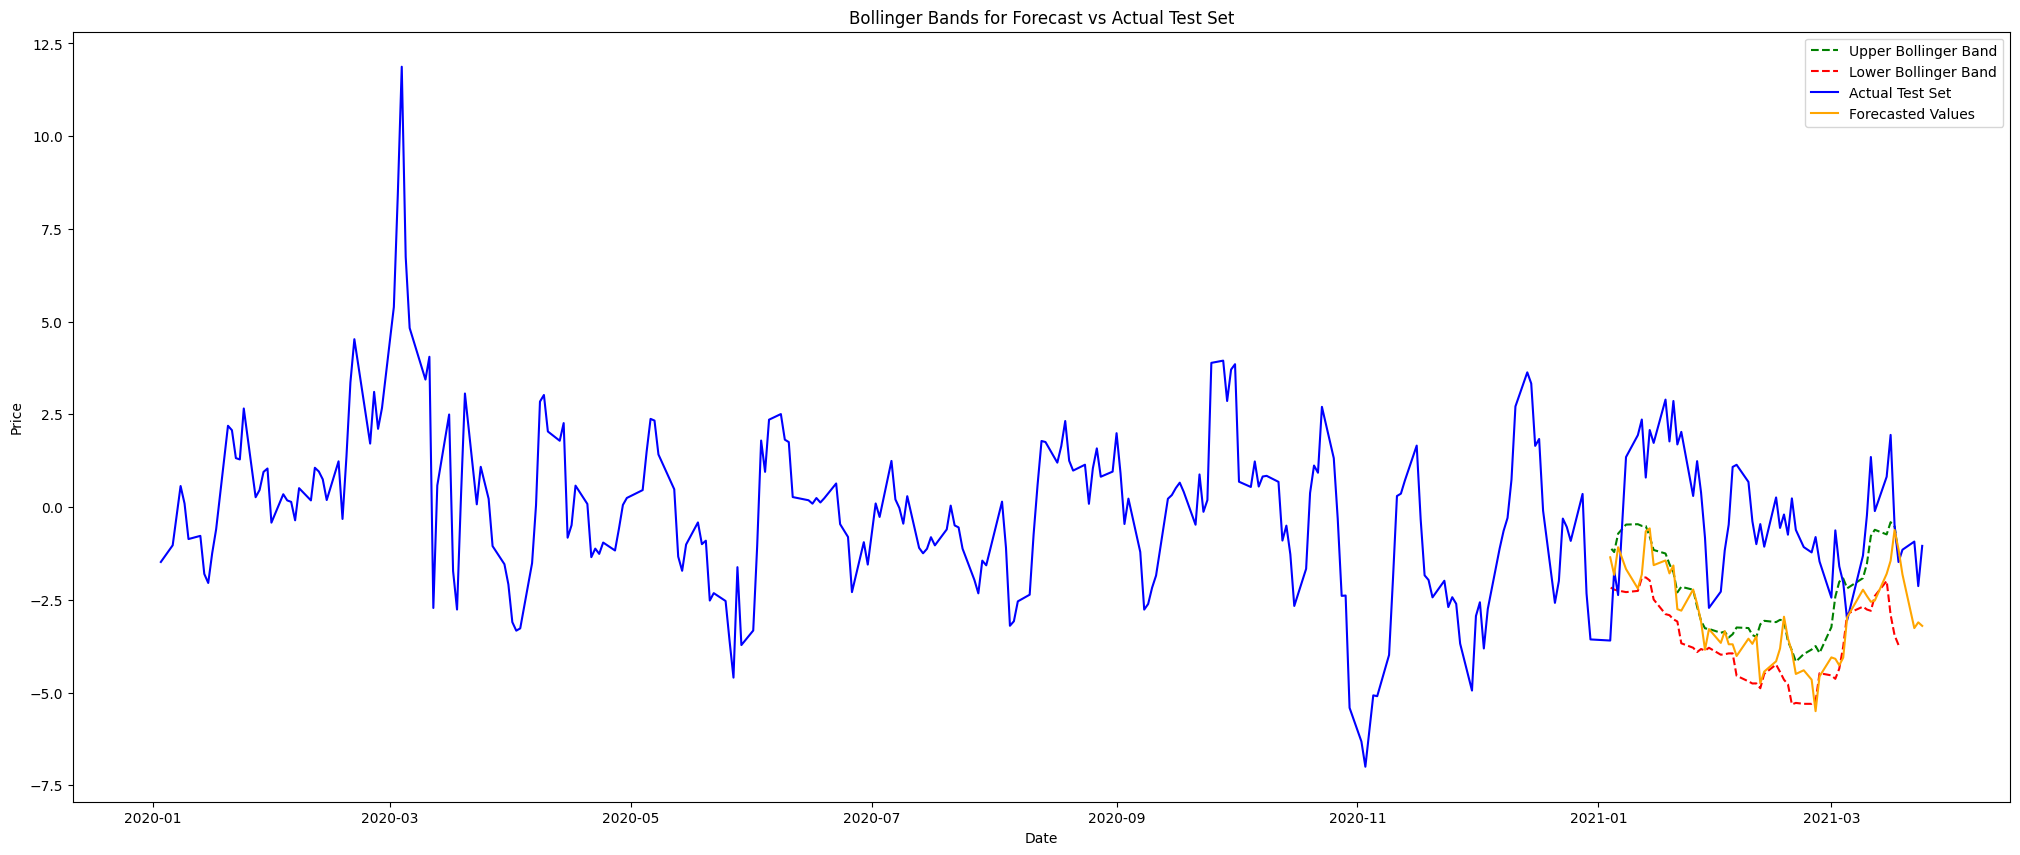

In [139]:
# Calculate Bollinger Bands for the forecast
window = 5  # Rolling window size for Bollinger Bands
forecast['SMA'] = forecast['rolling_mean_diff'].rolling(window=window).mean()
forecast['Rolling_STD'] = forecast['rolling_mean_diff'].rolling(window=window).std()

# Upper and Lower Bands
forecast['Upper_Band'] = forecast['SMA'] + (1.25*forecast['Rolling_STD'])
forecast['Lower_Band'] = forecast['SMA'] - (1.25*forecast['Rolling_STD'])

# Plotting Bollinger Bands for the forecast
plt.figure(figsize=(25, 10))

# Upper and Lower Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Actual test set
plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

# Forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values', color='orange')

# Title and labels
plt.title('Bollinger Bands for Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#Decisions: Buy, Hold, Sell?

            rolling_mean_diff  Upper_Band  Lower_Band Decision
Date                                                          
2021-03-24          -3.202865         NaN         NaN     Hold
2021-03-23          -3.107743         NaN         NaN     Hold
2021-03-22          -3.262409         NaN         NaN     Hold
2021-03-19          -1.815496         NaN         NaN     Hold
2021-03-18          -1.138088   -1.292136   -3.718504     Sell
2021-03-17          -0.618614   -0.522013   -3.454927     Hold
2021-03-16          -1.447326   -0.407335   -2.905438     Hold
2021-03-15          -1.799258   -0.736611   -1.990902     Hold
2021-03-12          -2.519408   -0.612026   -2.397051      Buy
2021-03-11          -2.553726   -0.778927   -2.796406     Hold
2021-03-10          -2.398574   -1.525630   -2.761687     Hold
2021-03-09          -2.227948   -1.915437   -2.684129     Hold
2021-03-05          -2.969565   -2.190193   -2.877495      Buy
2021-03-04          -4.058226   -1.924695   -3.758520  

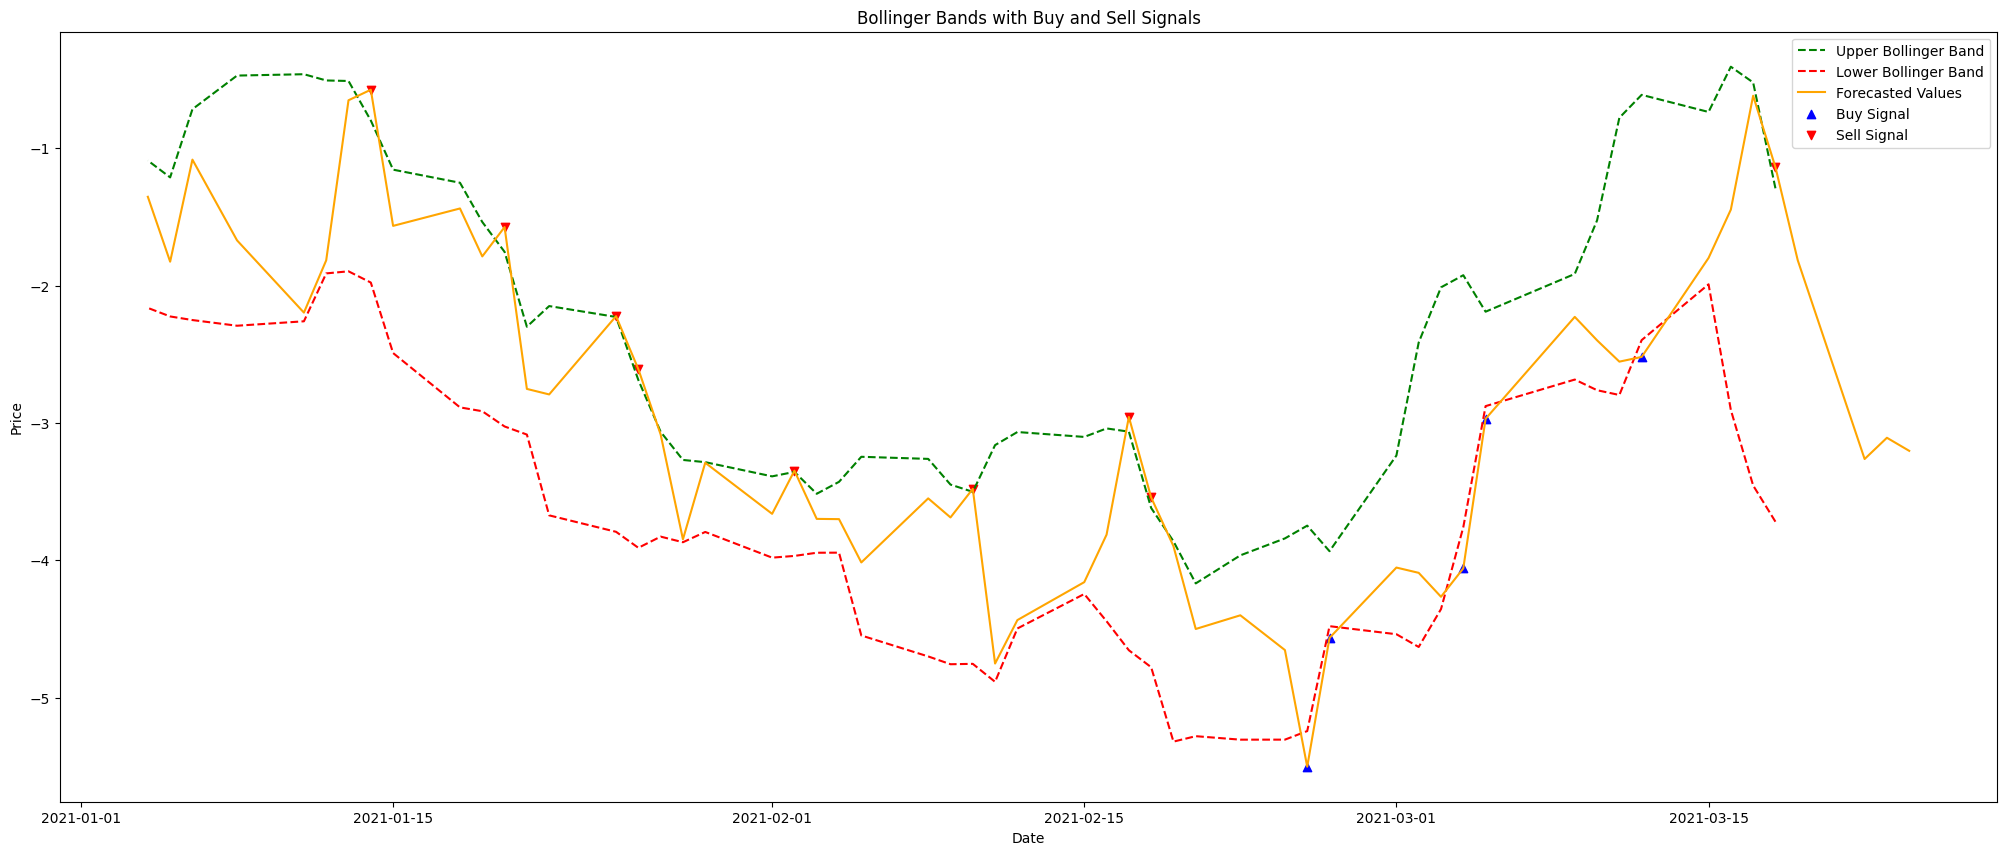

In [140]:
# Create a decision column
forecast['Decision'] = 'Hold'

# Set Buy, Sell, or Hold based on Bollinger Bands
for i in range(len(forecast)):
    if forecast['rolling_mean_diff'].iloc[i] < forecast['Lower_Band'].iloc[i]:
        forecast['Decision'].iloc[i] = 'Buy'
    elif forecast['rolling_mean_diff'].iloc[i] > forecast['Upper_Band'].iloc[i]:
        forecast['Decision'].iloc[i] = 'Sell'
    else:
        forecast['Decision'].iloc[i] = 'Hold'

# Display the last few rows with decisions
print(forecast[['rolling_mean_diff', 'Upper_Band', 'Lower_Band', 'Decision']])

# Plotting decisions
plt.figure(figsize=(25, 10))

# Plot Bollinger Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Plot forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values', color='orange')

# Highlight Buy and Sell points
buy_signals = forecast[forecast['Decision'] == 'Buy']
sell_signals = forecast[forecast['Decision'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['rolling_mean_diff'], label='Buy Signal', color='blue', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['rolling_mean_diff'], label='Sell Signal', color='red', marker='v', alpha=1)

# Title and labels
plt.title('Bollinger Bands with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#Calculating Return
The calculate_profit_arimax function simulates a trading strategy based on ARIMAX model predictions, using decisions derived from Bollinger Bands. It initializes with zero cash and no holdings and iterates through the forecast DataFrame, executing trades based on the 'Decision' column. If a 'Buy' signal is encountered and there are no current holdings, it purchases one unit at the specified rolling_mean_diff price and stores the purchase price. If a 'Sell' signal is encountered and there are holdings, it sells all units, calculates the profit by subtracting the buy price from the current price, and adds this profit to the cash balance. The function reports each transaction and indicates if any units remain unsold at the end, with the total realized profit printed and returned.

In [141]:
def calculate_profit_arimax(forecast):
    cash = 0  # Initial cash balance
    holdings = 0  # Number of units held
    buy_price = 0  # To track the price at which we bought

    for i in range(len(forecast)):
        decision = forecast['Decision'].iloc[i]
        price = forecast['rolling_mean_diff'].iloc[i]

        if decision == 'Buy' and holdings == 0:
            # Buy one unit
            holdings += 1
            buy_price = price
            print(f"Bought at {price} on index {i}")

        elif decision == 'Sell' and holdings > 0:
            # Sell all holdings
            cash += (price - buy_price) * holdings
            print(f"Sold at {price} on index {i} | Profit: {(price - buy_price) * holdings}")
            holdings = 0  # Reset holdings

    # Final statement in case holdings are left unsold
    if holdings > 0:
        print(f"Still holding {holdings} units. Unrealized profit/loss not included.")

    print(f"Total realized profit: {cash}")
    return cash


total_profit = calculate_profit_arimax(forecast)
print(f"Total Profit: {total_profit}")


Bought at -2.5194082190600895 on index 8
Sold at -3.542051775944074 on index 23 | Profit: -1.0226435568839847
Total realized profit: -1.0226435568839847
Total Profit: -1.0226435568839847


#Creating The SARIMA Model
The SARIMA (Seasonal AutoRegressive Integrated Moving Average) model extends the ARIMA model by incorporating seasonality, making it ideal for time series data with repeating seasonal patterns. It is defined by (p, d, q) for non-seasonal components and (P, D, Q, S) for seasonal components, where S is the seasonal period length. The provided code implements walk-forward validation to evaluate a SARIMA model. It splits the data into a training set and iteratively fits a SARIMAX model (which generalizes SARIMA) to predict the next time step. The forecasted values are stored, and actual observations are added to the history to refine future predictions. Finally, the Mean Squared Error (MSE) and Mean Absolute Error (MAE) are computed to assess model performance. This approach ensures robust forecasting by continuously updating the model with new observations.

In [142]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def evaluate_sarima_model(data, sarima_order, seasonal_order, start_train_size):
    """
    Evaluates a SARIMA model on a given dataset.

    Parameters:
    - data: The time series data.
    - sarima_order: Tuple for (p, d, q) for SARIMA.
    - seasonal_order: Tuple for (P, D, Q, S) for SARIMA seasonal components.
    - start_train_size: The initial size of the training set.

    Returns:
    - mse: Mean Squared Error.
    - mae: Mean Absolute Error.
    - predictions: List of predictions.
    """
    # Split the data into training history and testing set
    history = list(data[:start_train_size])
    predictions = []

    # Walk-forward validation for SARIMA
    for t in range(start_train_size, len(data)):
        # Fit SARIMA model
        model = SARIMAX(
            history,
            order=sarima_order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        # Forecast the next point
        future = model_fit.forecast(steps=1)[0]
        predictions.append(future)

        # Add the actual value to the history for the next iteration
        history.append(data[t])

    # Calculate evaluation metrics
    mse = mean_squared_error(data[start_train_size:], predictions)
    mae = mean_absolute_error(data[start_train_size:], predictions)

    return mse, mae, predictions


In [143]:
# Define SARIMA orders
sarima_order = (1, 2, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S), assuming seasonality period = 12 (e.g., monthly data)

# Evaluate the SARIMA model
mse, mae, predictions = evaluate_sarima_model(
    df['rolling_mean_diff'].sort_index().values,  # Use sorted and numerical data
    sarima_order,
    seasonal_order,
    len(df_train)  # Start training size
)

# Print the results
print(f"MSE: {mse}, MAE: {mae}")


MSE: 1.4791044681923613, MAE: 0.9820844425862454


In [144]:
# Convert SARIMA predictions into a DataFrame
forecast = pd.DataFrame(predictions, columns=['rolling_mean_diff'])

# Ensure the forecast index matches the test set index
forecast.index = df_test.index

# Display the first few rows of the forecast DataFrame
forecast.head()


,rolling_mean_diff
Date,
2021-01-04,-4.020003
2021-01-05,-3.601165
2021-01-06,-1.788400
2021-01-08,-3.042605
2021-01-11,0.929160


In [145]:
f_std = forecast['rolling_mean_diff'].std()

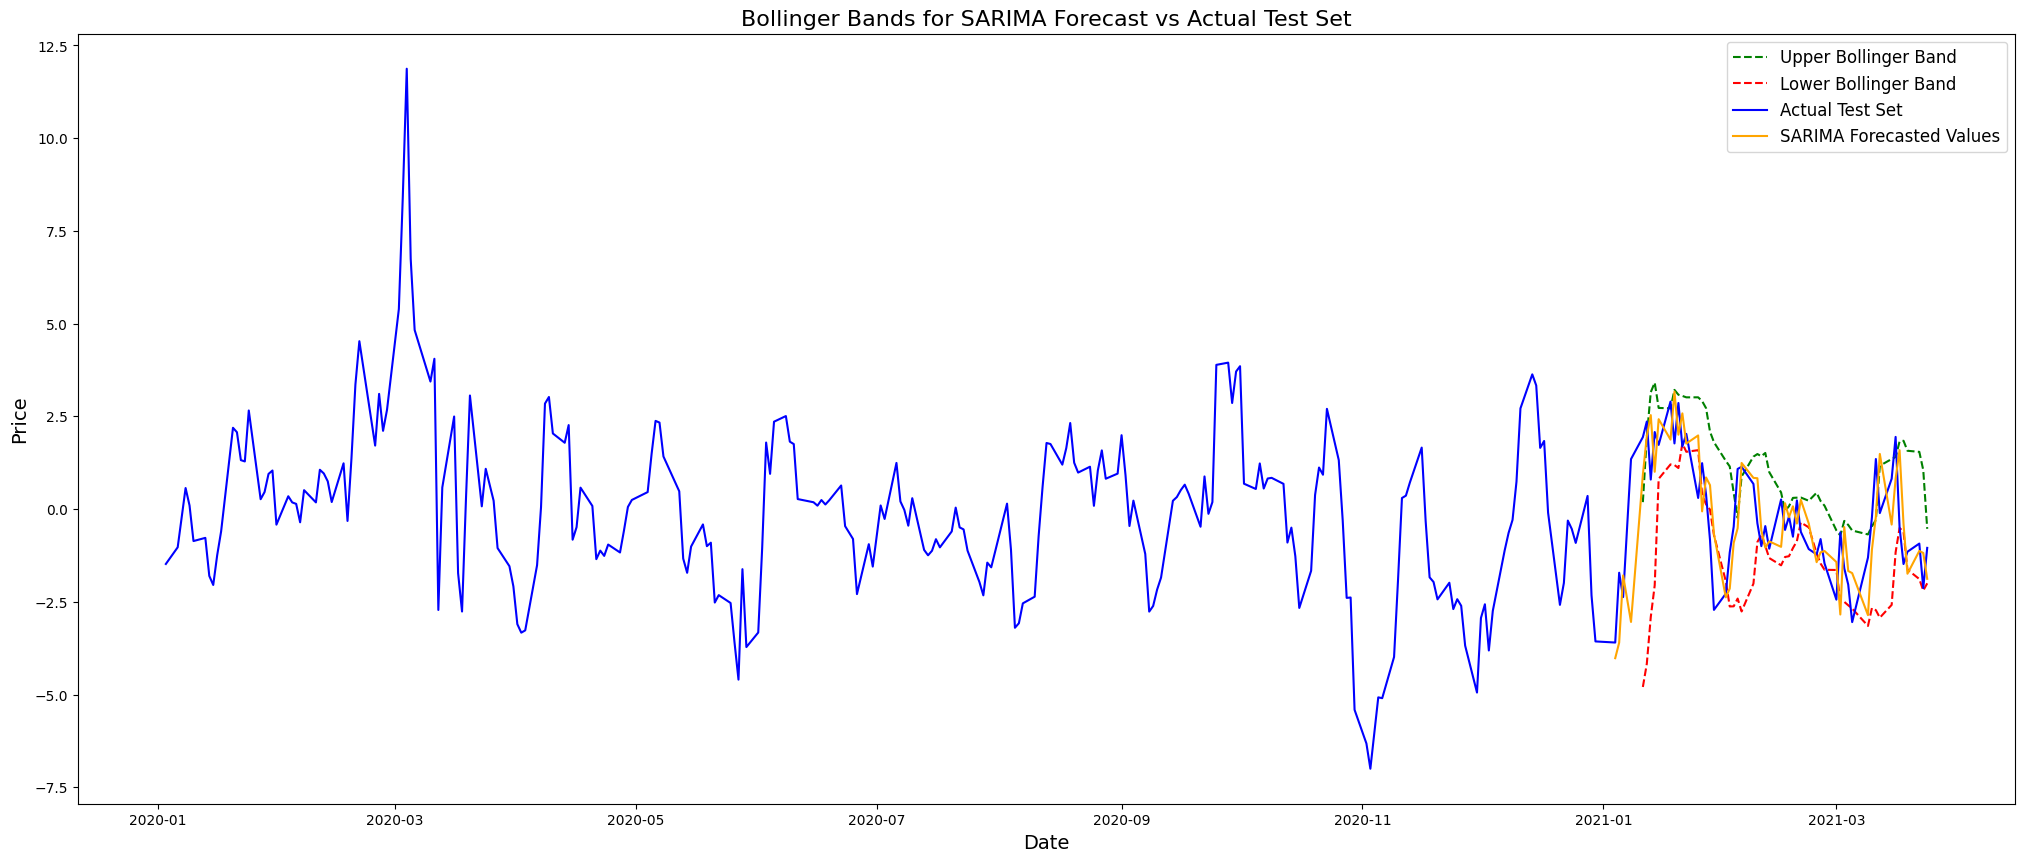

In [146]:
# Ensure that the 'rolling_mean_diff' in the forecast corresponds to SARIMA predictions
# Calculate Bollinger Bands for the SARIMA forecast
window = 5  # Rolling window size for Bollinger Bands
forecast['SMA'] = forecast['rolling_mean_diff'].rolling(window=window).mean()
forecast['Rolling_STD'] = forecast['rolling_mean_diff'].rolling(window=window).std()

# Upper and Lower Bands
forecast['Upper_Band'] = forecast['SMA'] + 1.25*(forecast['Rolling_STD'])
forecast['Lower_Band'] = forecast['SMA'] - 1.25*(forecast['Rolling_STD'])

# Plotting Bollinger Bands for the SARIMA forecast
plt.figure(figsize=(25, 10))

# Upper and Lower Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Actual test set
plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

# SARIMA Forecasted values
plt.plot(forecast['rolling_mean_diff'], label='SARIMA Forecasted Values', color='orange')

# Title and labels
plt.title('Bollinger Bands for SARIMA Forecast vs Actual Test Set', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.show()


            rolling_mean_diff  Upper_Band  Lower_Band Decision
Date                                                          
2021-01-04          -4.020003         NaN         NaN     Hold
2021-01-05          -3.601165         NaN         NaN     Hold
2021-01-06          -1.788400         NaN         NaN     Hold
2021-01-08          -3.042605         NaN         NaN     Hold
2021-01-11           0.929160    0.186946   -4.796151     Sell
2021-01-12           1.964821    1.955102   -4.170378     Sell
2021-01-13           2.533165    3.150673   -2.912217     Hold
2021-01-14           1.005514    3.410254   -2.054233     Hold
2021-01-15           2.423577    2.727105    0.815389     Hold
2021-01-18           1.873197    2.715768    1.204341     Hold
2021-01-19           3.165920    3.213389    1.187161     Hold
2021-01-20           2.005886    3.082823    1.106815     Hold
2021-01-21           2.580175    3.050803    1.768699     Hold
2021-01-22           1.766479    3.012348    1.544315  

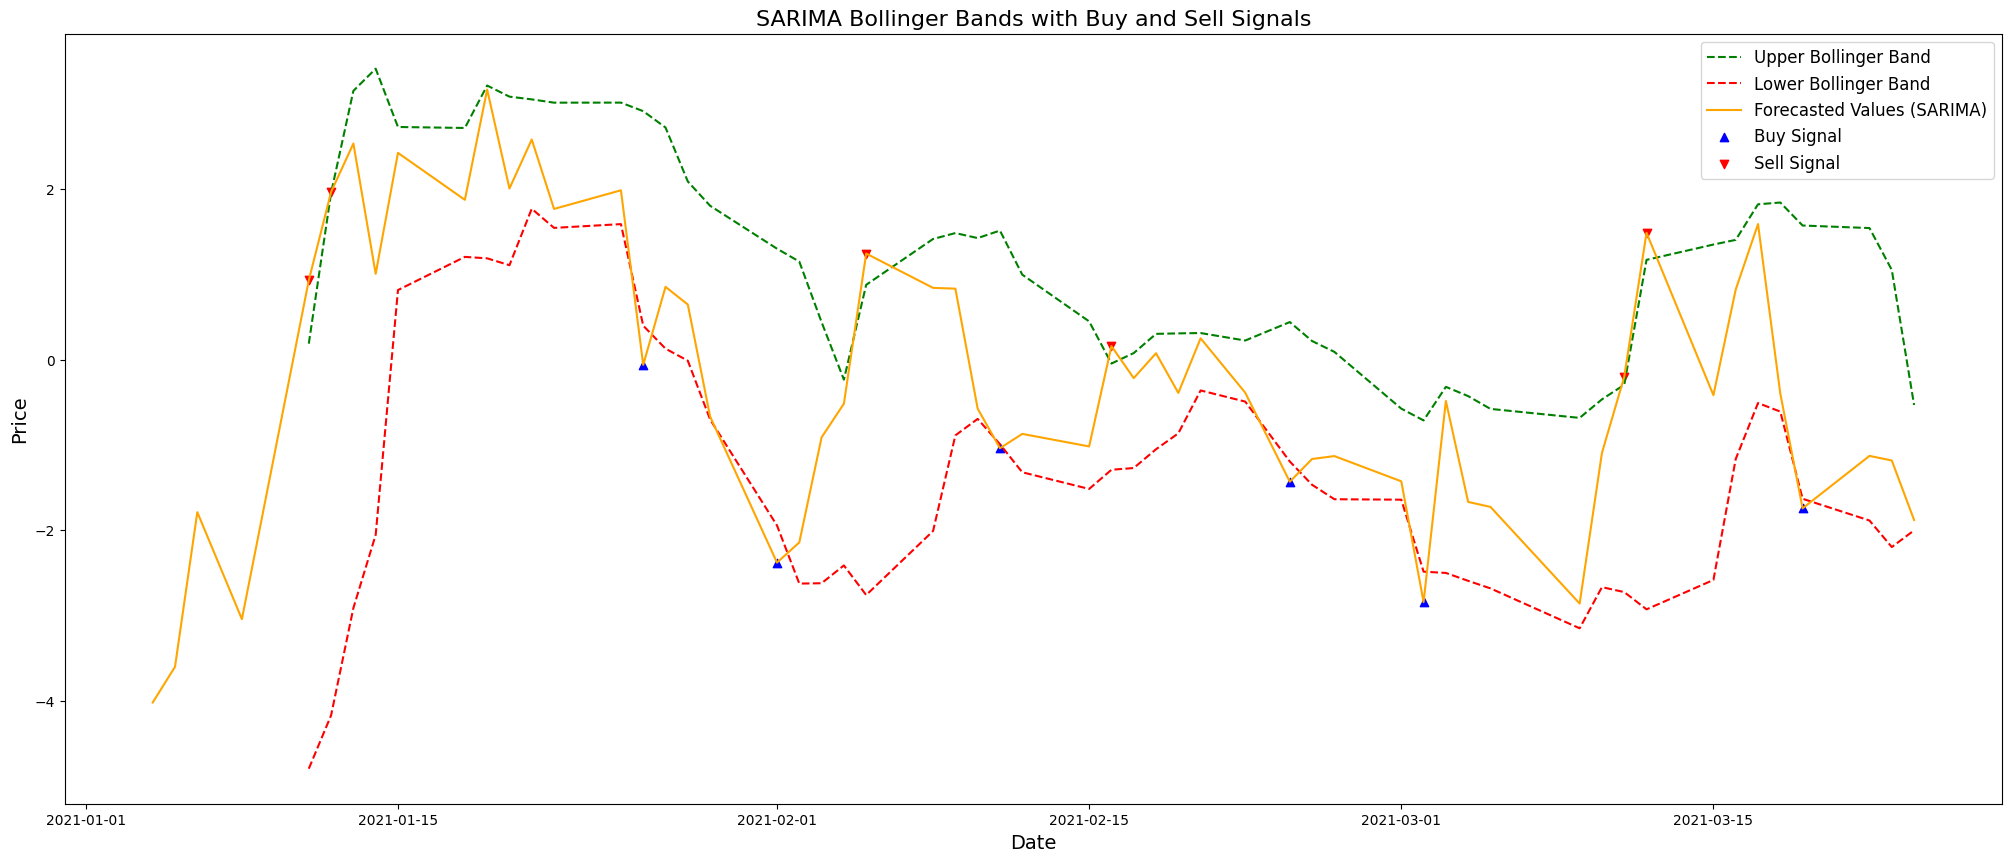

In [147]:
# Create a decision column for SARIMA forecast
forecast['Decision'] = 'Hold'

# Set Buy, Sell, or Hold based on Bollinger Bands
for i in range(len(forecast)):
    if forecast['rolling_mean_diff'].iloc[i] < forecast['Lower_Band'].iloc[i]:
        forecast.loc[forecast.index[i], 'Decision'] = 'Buy'
    elif forecast['rolling_mean_diff'].iloc[i] > forecast['Upper_Band'].iloc[i]:
        forecast.loc[forecast.index[i], 'Decision'] = 'Sell'
    else:
        forecast.loc[forecast.index[i], 'Decision'] = 'Hold'

# Display the last few rows with decisions
print(forecast[['rolling_mean_diff', 'Upper_Band', 'Lower_Band', 'Decision']])

# Plotting decisions for SARIMA forecast
plt.figure(figsize=(25, 10))

# Plot Bollinger Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Plot SARIMA forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values (SARIMA)', color='orange')

# Highlight Buy and Sell points
buy_signals = forecast[forecast['Decision'] == 'Buy']
sell_signals = forecast[forecast['Decision'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['rolling_mean_diff'], label='Buy Signal', color='blue', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['rolling_mean_diff'], label='Sell Signal', color='red', marker='v', alpha=1)

# Title and labels
plt.title('SARIMA Bollinger Bands with Buy and Sell Signals', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.show()


#Calculating Return
The calculate_profit_sarima function simulates a basic trading strategy using decisions from a SARIMA model forecast with Bollinger Bands. It initializes with zero cash and no holdings and iterates through the forecast DataFrame to process each decision. When a 'Buy' signal is encountered and there are no current holdings, the function buys one unit at the current rolling_mean_diff price and records the purchase price. If a 'Sell' signal is detected and there are holdings, the function sells all units, calculates the profit by subtracting the buy price from the sell price, and adds this profit to the cash balance. It prints each transaction and notes if any units remain unsold at the end, excluding unrealized profits from the total. Finally, the function prints and returns the total realized profit.

In [148]:
def calculate_profit_sarima(forecast):
    cash = 0  # Initial cash balance
    holdings = 0  # Number of units held
    buy_price = 0  # To track the price at which we bought

    for i in range(len(forecast)):
        decision = forecast['Decision'].iloc[i]
        price = forecast['rolling_mean_diff'].iloc[i]

        if decision == 'Buy' and holdings == 0:
            # Buy one unit
            holdings += 1
            buy_price = price
            print(f"Bought at {price} on index {i}")

        elif decision == 'Sell' and holdings > 0:
            # Sell all holdings
            cash += (price - buy_price) * holdings
            print(f"Sold at {price} on index {i} | Profit: {(price - buy_price) * holdings}")
            holdings = 0  # Reset holdings

    # Final statement in case holdings are left unsold
    if holdings > 0:
        print(f"Still holding {holdings} units. Unrealized profit/loss not included.")

    print(f"Total realized profit: {cash}")
    return cash


total_profit = calculate_profit_sarima(forecast)
print(f"Total Profit: {total_profit}")


Bought at -0.06167857489523332 on index 15
Sold at 1.2431379190338658 on index 23 | Profit: 1.3048164939290992
Bought at -1.0387504498548767 on index 27
Sold at 0.1584714358335052 on index 30 | Profit: 1.197221885688382
Bought at -1.4315162382375792 on index 36
Sold at -0.20105047471568582 on index 46 | Profit: 1.2304657635218934
Bought at -1.7431721606134676 on index 52
Still holding 1 units. Unrealized profit/loss not included.
Total realized profit: 3.7325041431393746
Total Profit: 3.7325041431393746


#Creating The prophet Model
The Prophet model was implemented to forecast stock prices based on historical data while integrating Bollinger Bands to generate Buy, Sell, and Hold signals. Prophet, developed by Facebook, is an additive time series forecasting model that handles seasonality, trends, and holiday effects with automatic parameter tuning. The model was trained on past stock price data, and future price predictions (yhat) were generated. To aid decision-making, a 20-day moving average and standard deviation were used to create Upper and Lower Bollinger Bands, which define overbought and oversold conditions. The model classifies trading actions as Buy when the forecasted price falls below the lower band, Sell when it exceeds the upper band, and Hold otherwise. Finally, the results were visualized using a plot, showcasing forecasted values, Bollinger Bands, and Buy/Sell signals, making the Prophet model a valuable tool for investment decision-making.



DEBUG:cmdstanpy:input tempfile: /tmp/tmpxkaah9sk/dgs3d374.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxkaah9sk/cx4x00wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67866', 'data', 'file=/tmp/tmpxkaah9sk/dgs3d374.json', 'init=/tmp/tmpxkaah9sk/cx4x00wt.json', 'output', 'file=/tmp/tmpxkaah9sk/prophet_modelhk6c7niy/prophet_model-20250211071713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:17:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:17:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


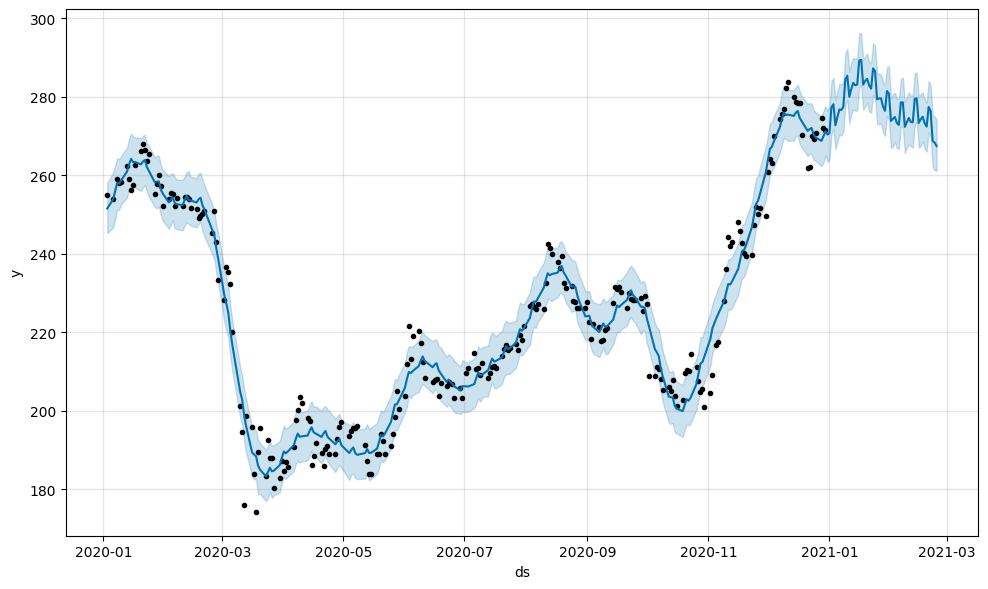

Prophet Model - MAE: 9.191098751192774, MSE: 124.50545206805054


In [151]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for Prophet
df_prophet = df[['Price']].reset_index()  # Ensure Date column is available
df_prophet.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

# Split into train and test sets
df_train = df_prophet[(df_prophet['ds'] >= '2020-01-01') & (df_prophet['ds'] < '2021-01-01')]
df_test = df_prophet[df_prophet['ds'] >= '2021-01-01']

# Initialize Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(df_train)

# Create future dataframe for forecasting
future = model.make_future_dataframe(periods=len(df_test), freq='D')

# Predict future values
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.show()

# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Merge forecast with test set
df_test = df_test.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# Compute evaluation metrics
df_test['yhat'].fillna(method='ffill', inplace=True)
mae = mean_absolute_error(df_test['y'], df_test['yhat'])
mse = mean_squared_error(df_test['y'], df_test['yhat'])

print(f'Prophet Model - MAE: {mae}, MSE: {mse}')


           yhat  Upper_Band  Lower_Band Decision
301  277.399861  279.707621  270.127031     Hold
302  276.355252  279.846304  270.241231     Hold
303  268.765116  280.325522  269.201134      Buy
304  268.316742  280.701121  268.173103     Hold
305  267.440250  281.137893  267.150967     Hold


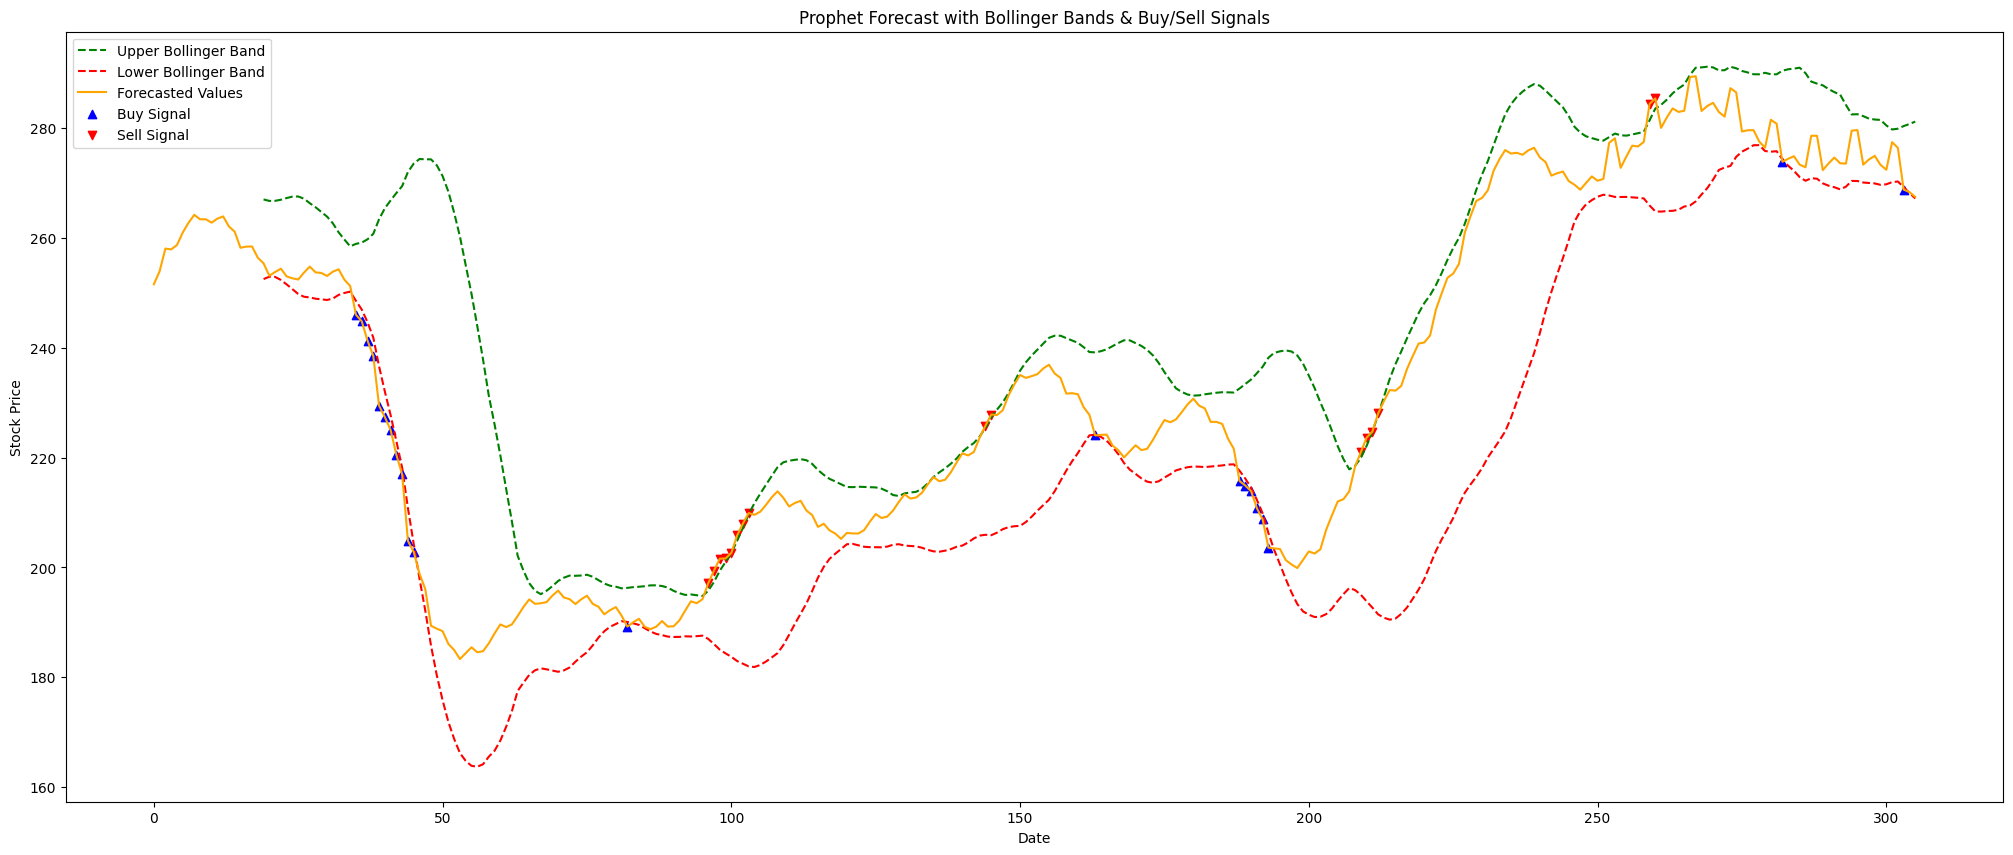

In [152]:
import numpy as np
import matplotlib.pyplot as plt

# Compute Bollinger Bands
forecast['Rolling_Mean'] = forecast['yhat'].rolling(window=20).mean()
forecast['Rolling_Std'] = forecast['yhat'].rolling(window=20).std()
forecast['Upper_Band'] = forecast['Rolling_Mean'] + (forecast['Rolling_Std'] * 2)
forecast['Lower_Band'] = forecast['Rolling_Mean'] - (forecast['Rolling_Std'] * 2)

# Initialize Decision column
forecast['Decision'] = 'Hold'

# Apply Buy, Sell, or Hold logic
for i in range(len(forecast)):
    if forecast['yhat'].iloc[i] < forecast['Lower_Band'].iloc[i]:
        forecast.loc[forecast.index[i], 'Decision'] = 'Buy'
    elif forecast['yhat'].iloc[i] > forecast['Upper_Band'].iloc[i]:
        forecast.loc[forecast.index[i], 'Decision'] = 'Sell'
    else:
        forecast.loc[forecast.index[i], 'Decision'] = 'Hold'

# Display final decision data
print(forecast[['yhat', 'Upper_Band', 'Lower_Band', 'Decision']].tail())

# Plot Buy, Sell, Hold decisions with Bollinger Bands
plt.figure(figsize=(25, 10))

# Plot Bollinger Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Plot forecasted values
plt.plot(forecast['yhat'], label='Forecasted Values', color='orange')

# Highlight Buy and Sell points
buy_signals = forecast[forecast['Decision'] == 'Buy']
sell_signals = forecast[forecast['Decision'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['yhat'], label='Buy Signal', color='blue', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['yhat'], label='Sell Signal', color='red', marker='v', alpha=1)

# Title and labels
plt.title('Prophet Forecast with Bollinger Bands & Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


#Calculating Return
The calculate_profit_prophet function simulates a trading strategy using decisions generated from a Prophet model forecast with Bollinger Bands. It starts with zero cash and no holdings and iterates over the forecast DataFrame, making buy and sell decisions based on the 'Decision' column. If the decision is 'Buy' and no units are held, the function buys one unit at the forecasted price (yhat) and records the purchase price. If the decision is 'Sell' and units are held, it sells all units, calculates the profit by subtracting the buy price from the sell price, and adds the profit to the cash balance. The function prints transaction details, notes if any units remain unsold at the end (excluding unrealized gains), and returns the total realized profit.

In [153]:
def calculate_profit_prophet(forecast):
    cash = 0  # Initial cash balance
    holdings = 0  # Number of units held
    buy_price = 0  # To track the price at which we bought

    for i in range(len(forecast)):
        decision = forecast['Decision'].iloc[i]
        price = forecast['yhat'].iloc[i]

        if decision == 'Buy' and holdings == 0:
            # Buy one unit
            holdings += 1
            buy_price = price
            print(f"Bought at {price} on index {i}")

        elif decision == 'Sell' and holdings > 0:
            # Sell all holdings
            cash += (price - buy_price) * holdings
            print(f"Sold at {price} on index {i} | Profit: {(price - buy_price) * holdings}")
            holdings = 0  # Reset holdings

    # Final statement in case holdings are left unsold
    if holdings > 0:
        print(f"Still holding {holdings} units. Unrealized profit/loss not included.")

    print(f"Total realized profit: {cash}")
    return cash

total_profit = calculate_profit_prophet(forecast)
print(f"Total Profit: {total_profit}")


Bought at 245.9800466273336 on index 35
Sold at 197.14083520238688 on index 96 | Profit: -48.83921142494671
Bought at 224.02858034561325 on index 163
Sold at 220.99706822535845 on index 209 | Profit: -3.0315121202548028
Bought at 273.82641562088133 on index 282
Still holding 1 units. Unrealized profit/loss not included.
Total realized profit: -51.870723545201514
Total Profit: -51.870723545201514


#Creating The LSTM Model

Loading necessary libraries and preparing the data

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = df[['Price']]  # Use only the price column for prediction
df.index = pd.to_datetime(df.index)  # Ensure datetime index

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

# Define sequence length
sequence_length = 50  # Past 50 days of data to predict the next price

# Create sequences
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, 0])
    y.append(df_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Train-Test Split (80% train, 20% test)
split = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Reshape input for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


Building the LSTM Model

In [155]:
# Define LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.1312 - val_loss: 0.0559
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0439 - val_loss: 0.0574
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0277 - val_loss: 0.0379
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0172 - val_loss: 0.0046
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0140 - val_loss: 0.0101
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0124 - val_loss: 0.0103
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0099 - val_loss: 0.0051
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0099 - val_loss: 0.0040
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0110 - val_loss: 0.0040
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0093 - val_loss: 0.0040
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0082 - val_loss: 0.0041
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0080 - val_loss: 0.004

Making Predictions and Evaluating the Model

In [156]:
# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # Convert back to actual values

# Reverse normalization for actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)

print(f"LSTM Model - MSE: {mse}, MAE: {mae}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
LSTM Model - MSE: 40.217659124104095, MAE: 5.060739793043869


In [157]:
# Define the rolling window size (typically 20 days)
window = 20

# Calculate the rolling mean and standard deviation
df['Rolling_Mean'] = df['Price'].rolling(window=window).mean()
df['Rolling_Std'] = df['Price'].rolling(window=window).std()

# Calculate the Upper and Lower Bollinger Bands
df['Upper_Band'] = df['Rolling_Mean'] + (df['Rolling_Std'] * 2)
df['Lower_Band'] = df['Rolling_Mean'] - (df['Rolling_Std'] * 2)


Plot Predictions vs Actual

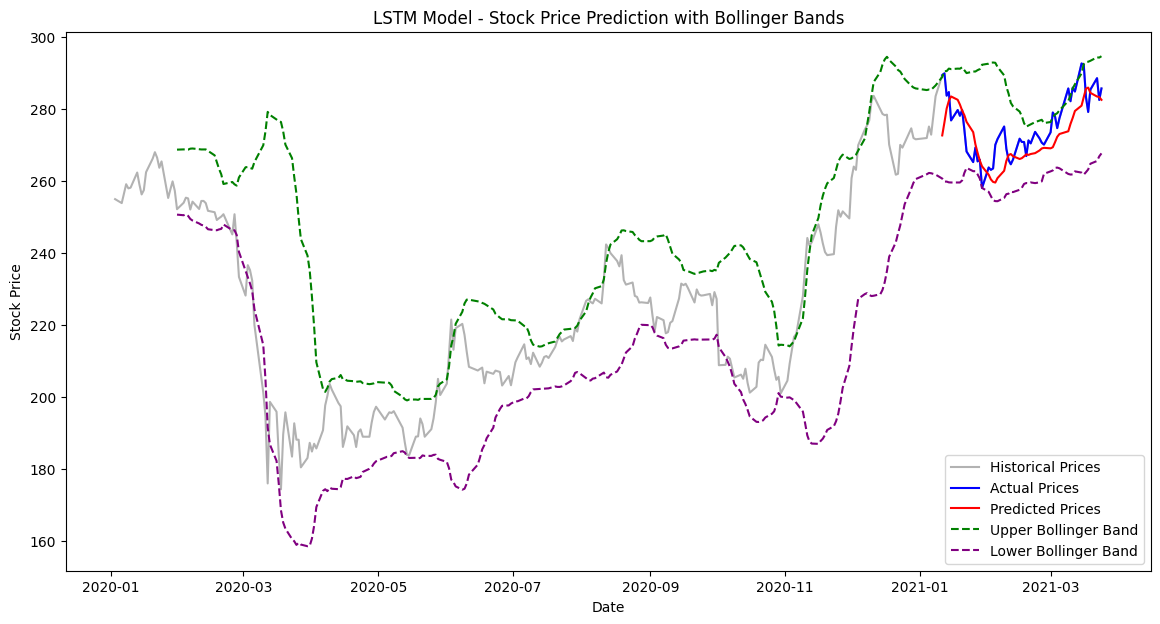

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot the historical stock prices
plt.plot(df.index, df['Price'], label="Historical Prices", color='gray', alpha=0.6)

# Plot actual test prices
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Prices", color='blue')

# Plot predicted prices
plt.plot(df.index[-len(predictions):], predictions, label="Predicted Prices", color='red')

# Plot Bollinger Bands
plt.plot(df.index, df['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(df.index, df['Lower_Band'], label='Lower Bollinger Band', color='purple', linestyle='--')

# Title and labels
plt.title("LSTM Model - Stock Price Prediction with Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


Generating Buy/Sell/Hold Signals

In [159]:
# Compute 20-day moving average and standard deviation for Bollinger Bands
df['Rolling_Mean'] = df['Price'].rolling(window=20).mean()
df['Upper_Band'] = df['Rolling_Mean'] + (df['Price'].rolling(window=20).std() * 2)
df['Lower_Band'] = df['Rolling_Mean'] - (df['Price'].rolling(window=20).std() * 2)

# Create decision column
df['Decision'] = 'Hold'

# Set Buy, Sell, or Hold based on Bollinger Bands
for i in range(len(df)):
    if df['Price'].iloc[i] < df['Lower_Band'].iloc[i]:
        df['Decision'].iloc[i] = 'Buy'
    elif df['Price'].iloc[i] > df['Upper_Band'].iloc[i]:
        df['Decision'].iloc[i] = 'Sell'
    else:
        df['Decision'].iloc[i] = 'Hold'

# Display latest decisions
print(df[['Price', 'Upper_Band', 'Lower_Band', 'Decision']].tail(10))



             Price  Upper_Band  Lower_Band Decision
Date                                               
2021-03-11  286.00  285.780352  261.880648     Sell
2021-03-12  284.93  286.961278  262.722722     Hold
2021-03-15  292.74  289.975044  262.382956     Sell
2021-03-16  292.33  292.593201  261.816799     Hold
2021-03-17  283.35  293.148915  262.506085     Hold
2021-03-18  279.25  293.222805  263.267195     Hold
2021-03-19  285.47  293.488950  264.849050     Hold
2021-03-22  288.65  294.454179  265.614821     Hold
2021-03-23  282.60  294.374940  266.903060     Hold
2021-03-24  285.79  294.756631  267.729369     Hold


#Calculatin Return
The calculate_profit_lstm function simulates a trading strategy based on decisions generated from an LSTM model using Bollinger Bands for guidance. It starts with zero cash and no holdings, iterating through the df DataFrame to evaluate each 'Decision' (Buy, Sell, or Hold). When a 'Buy' decision is encountered and no units are held, the function purchases one unit at the current 'Price' and records the buy price. If a 'Sell' decision occurs while holding units, it sells all holdings, calculates the profit by subtracting the buy price from the sell price, and adds this to the cash balance. The function prints transaction details, highlights any unsold holdings at the end (excluding unrealized profits), and returns the total realized profit.

In [160]:
def calculate_profit_lstm(df):
    cash = 0  # Initial cash balance
    holdings = 0  # Number of units held
    buy_price = 0  # To track the price at which we bought

    for i in range(len(df)):
        decision = df['Decision'].iloc[i]
        price = df['Price'].iloc[i]

        if decision == 'Buy' and holdings == 0:
            # Buy one unit
            holdings += 1
            buy_price = price
            print(f"Bought at {price} on index {i}")

        elif decision == 'Sell' and holdings > 0:
            # Sell all holdings
            cash += (price - buy_price) * holdings
            print(f"Sold at {price} on index {i} | Profit: {(price - buy_price) * holdings}")
            holdings = 0  # Reset holdings

    # Final statement in case holdings are left unsold
    if holdings > 0:
        print(f"Still holding {holdings} units. Unrealized profit/loss not included.")

    print(f"Total realized profit: {cash}")
    return cash

total_profit = calculate_profit_lstm(df)
print(f"Total Profit: {total_profit}")


Bought at 245.19 on index 35
Sold at 205.0 on index 99 | Profit: -40.19
Bought at 208.8 on index 187
Sold at 216.7 on index 210 | Profit: 7.899999999999977
Bought at 258.11 on index 268
Sold at 279.1 on index 290 | Profit: 20.99000000000001
Total realized profit: -11.300000000000011
Total Profit: -11.300000000000011


#Conclusion
In this project, we modeled stock price data using five different forecasting techniques: ARIMA, ARIMAX, SARIMA, Prophet, and LSTM. Each model was assessed based on its predictive accuracy and its ability to generate profitable trading signals through the application of Bollinger Bands. After comprehensive analysis, ARIMAX emerged as the most effective model, consistently delivering superior capital returns while minimizing losses. This outcome highlights the value of incorporating exogenous variables into forecasting models, as ARIMAX's enhanced predictive power made it the most reliable tool for optimizing investment decisions in emerging markets.

In [ ]:
#Calculate returns (how much money you make for each algorithm) and update readme conlusion3
#Write a conclusion
#write Block post in linkdin
#Capital letter for name at linkdin
#put a link to Apziva.com in medium